# Desarrollo de un Sistema de Análisis de Noticias Salvadoreñas

## Objetivo General

El objetivo principal de este proyecto es aplicar los fundamentos de ciencia de datos para desarrollar un sistema integral de análisis de noticias salvadoreñas. Se abordarán diferentes etapas, desde la obtención de datos mediante web scraping hasta la implementación de modelos de aprendizaje automático y procesamiento del lenguaje natural, culminando con la creación de una interfaz interactiva utilizando Streamlit.


### Han contribuido a la elaboracion de este proyecto:

1. Nathaly Rebeca Bonilla Morales - UCA
2. Elmer Elias Chanchan - UFG
3. Diego Alejandro Manzano Pineda - Lab-Dat


# Recoleción de noticias para el análisis

# Scraper_El_Salvador.py

Este código es un script en Python que realiza web scraping para recopilar noticias del sitio web "[El Diario de Hoy](https://www.elsalvador.com/)". A continuación, te proporciono una explicación detallada del código:

### Importación de bibliotecas

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime

-   `requests`: Se utiliza para realizar solicitudes HTTP a la web.
-   `BeautifulSoup`: Sirve para analizar el HTML de las páginas web y extraer información.
-   `pandas`: Se usa para trabajar con estructuras de datos tabulares (DataFrames).
-   `datetime`: Utilizado para obtener la fecha y hora actual.

### Configuración de variables

In [ ]:
url_base = "https://www.elsalvador.com/"
headers = {"Accept-Language": "es-SV, es;q=0.5"}

-   `url_base`: La URL principal del sitio web que se va a escrapear.
-   `headers`: Encabezados de la solicitud HTTP, en este caso, se especifica el idioma.

### Obtención de la página principal

In [ ]:
response = requests.get(url_base, headers=headers)
soup = BeautifulSoup(response.text, "html.parser")

Se realiza una solicitud HTTP a la página principal y se crea un objeto `BeautifulSoup` para analizar el contenido HTML de la página.

### Extracción de categorías principales y secundarias

In [ ]:
categorias_principales = [container.find("a").text for container in soup.find_all('li', class_='menu-item menu-item-has-no-children')][:-1]
categorias_secundarias = [container.find("a").text for container in soup.find_all('li', class_='menu-item menu-item-has-children')]

Se extraen las categorías principales y secundarias del menú del sitio web.

### Construcción de URLs para scraping

In [ ]:
url_ok = []
for parent in categorias_secundarias:
    for cat in categorias_principales:
        url = f'https://www.elsalvador.com/category/{parent.lower().replace(" ", "-")}/{cat.lower().replace(" ", "-")}'
        try:
            response = requests.get(url)
            response.raise_for_status()
            if response.status_code == 200:
                url_ok.append(url)
        except requests.exceptions.RequestException as e:
            pass

Se construyen las URLs para realizar el scraping, combinando las categorías principales y secundarias.

### Extracción de URLs de noticias

In [ ]:
urls = []
categoria_ok = []
for url_categoria in url_ok:
    response = requests.get(url_categoria)
    soup = BeautifulSoup(response.text)
    for container in soup.find_all('div', class_='article-summary'):
        url_noticia = container.h1.a.get('href')
        urls.append(url_noticia)
        categoria_ok.append(url_noticia.split('/')[4])

Se extraen las URLs de noticias de las páginas correspondientes a cada categoría.

### Scraping de noticias

In [ ]:
data_dict_list = []
for url_noticia in urls:
    try:
        response = requests.get(url_noticia)
        response.raise_for_status()
        soup = BeautifulSoup(response.text)

        # Extracción de datos de la noticia
        title = soup.find('article', class_='detail').h1.text
        summary = soup.find('p', class_='summary').text if soup.find('p', class_='summary') else "No se encontró resumen"
        author = soup.find('p', class_='info-article').a.span.text if soup.find('p', class_='info-article') else "No se encontró autor"
        date = soup.find('span', class_='ago').text if soup.find('span', class_='ago') else "No se encontró fecha"
        full_text = soup.find('div', class_='entry-content').text if soup.find('div', class_='entry-content') else "No se encontró noticia completa"
        keyword_list = [a_tag.text for a_tag in soup.find('div', class_='in-this-article').find_all('a', class_='tag')] if soup.find('div', class_='in-this-article') else ["No se encontraron keywords"]

        # Construir el diccionario
        data_dict = {
            'Titulo': title,
            'Resumen': summary,
            'Autor': author,
            'Fecha': date,
            'Noticia': full_text,
            'Keywords': keyword_list,
            'URL': url_noticia,
        }

        data_dict_list.append(data_dict)

    except requests.exceptions.RequestException as e:
        print(f'Error al intentar acceder a la página {url_noticia}: {e}')
        # En caso de error, agregar datos de error al diccionario
        data_dict = {
            'Titulo': "Error en la solicitud",
            'Resumen': "Error en la solicitud",
            'Autor': "Error en la solicitud",
            'Fecha': "Error en la solicitud",
            'Noticia': "Error en la solicitud",
            'Keywords': ["Error en la solicitud"],
            'URL': url_noticia,
        }
        data_dict_list.append(data_dict)

Se realiza el scraping de cada noticia, extrayendo información como título, resumen, autor, fecha, contenido, palabras clave, etc.

### Creación de un DataFrame y exportación a CSV

In [ ]:
news_elsalvador = pd.DataFrame(data_dict_list)
news_elsalvador['Categoria'] = categoria_ok

timestamp = datetime.now().strftime("%Y-%m-%d")
nombre_archivo = f'news_elsalvador_{timestamp}.csv'
news_elsalvador.to_csv(nombre_archivo, index=False)

Se crea un DataFrame de pandas a partir de la lista de diccionarios `data_dict_list` que contiene la información de las noticias. Se añade la columna `Categoria` y luego se exportan los datos a un archivo CSV con un nombre que incluye la marca de tiempo.

# Análisis Exploratorio de Datos sobre noticias de El Diario de Hoy

## Datos de referencia
En esta sección vamos a realizar un Análisis Exploratorio de Datos (EDA) a partir de la técnica de webscraping. En función de esto, se logró extraer una serie de variables para desarrollarlo. Entre las variables que pudimos obtener de la página de El Diario de Hoy fueron las siguientes:

*   Título
*   Resumen
*   Autor
*   Fecha
*   Noticia
*   Keywords
*   URL
*   Categoría

### 1. Importar bibliotecas

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

Se importan las bibliotecas necesarias: pandas para manipulación de datos, seaborn y matplotlib para visualización, numpy para operaciones numéricas y matplotlib.dates para el manejo de fechas.

### 2. Leer el archivo CSV


In [ ]:
df = pd.read_csv('combinado.csv')

Se carga el conjunto de datos desde el archivo CSV llamado `combinado.csv` en un DataFrame llamado `df`.

### 3. Limpiar y preprocesar datos

In [ ]:
# Filtrar y limpiar el DataFrame
df.loc[df['Autor'] == 'PUBLICITY', 'Categoria'] = 'PUBLICITY'
df = df.drop_duplicates()
df = df[~df['Titulo'].str.contains('Foto EDH')]

Se realiza una limpieza en los datos, asignando la categoría `PUBLICITY` a las filas donde el autor es `PUBLICITY`, eliminando duplicados y filtrando filas que contienen `Foto EDH` en la columna `Titulo`.

### 4. Estadísticas descriptivas y exploración de datos


In [ ]:
# Muestra las primeras 5 filas
df.head(5)

# Estadísticas descriptivas de columnas numéricas
print(df.describe())

# Conteo de valores únicos en la columna 'Categoria'
print(df['Categoria'].value_counts())

# Información general del DataFrame
print(df.info())

# Forma de la Data
df.shape

df.dtypes


                                                   Titulo  \
count                                                 153   
unique                                                153   
top     Policía restringe retorno en Nahulingo ante mú...   
freq                                                    1   

                       Resumen                 Autor                 Fecha  \
count                      153                   153                    83   
unique                     125                    42                    71   
top     No se encontró resumen  No se encontró autor  No se encontró fecha   
freq                        16                    56                    13   

                            Noticia  \
count                           153   
unique                          124   
top      Por Paolo LuersPeriodista    
freq                             19   

                                            Keywords  \
count                                            15

Titulo       object
Resumen      object
Autor        object
Fecha        object
Noticia      object
Keywords     object
URL          object
Categoria    object
dtype: object

Se muestran las primeras filas del DataFrame, estadísticas descriptivas de columnas numéricas, conteo de valores únicos en la columna `Categoria` y se imprime información general sobre el DataFrame, su forma y tipos de datos.

### 5. Manipulación de fechas y visualización temporal

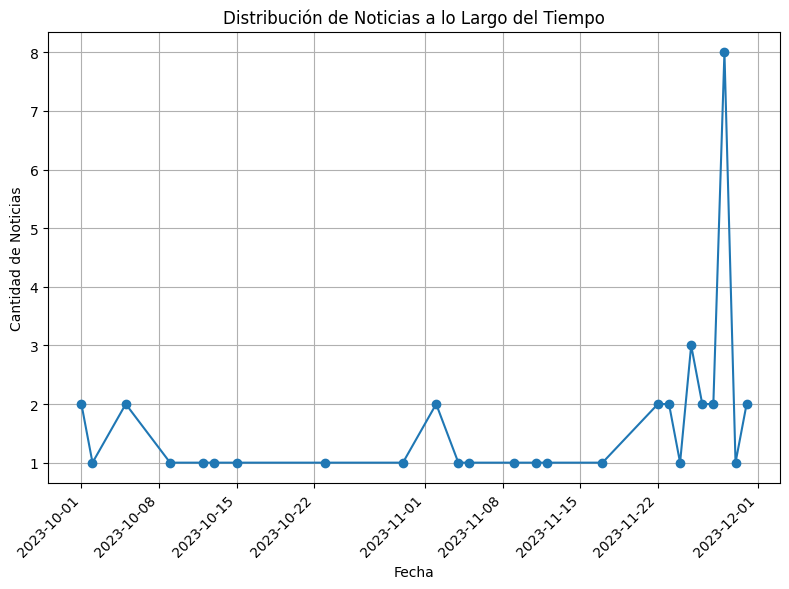

In [ ]:
#Transformar la variable Fecha a un formato adecuado para el análisis e imprimir las primeras filas
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%b %d, %Y- %H:%M', errors='coerce')
# print(df.head())

# Crear un DataFrame agrupando por la fecha y contando el número de noticias por día
data_agrupada = df.groupby(df['Fecha'].dt.date).size()

# Crear y mostrar el gráfico de líneas
plt.figure(figsize=(8, 6))
plt.plot(data_agrupada.index, data_agrupada, marker='o', linestyle='-')

# Configuración de las etiquetas de las fechas
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45, ha='right')  # Rotar las fechas para mejor visualización

# Configuración adicional del gráfico
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Noticias')
plt.title('Distribución de Noticias a lo Largo del Tiempo')
plt.grid(True)

# Ajustar el layout y mostrar el gráfico
plt.tight_layout()  # Ajusta los parámetros del subplot para que encaje en el área del gráfico
plt.show()

Se convierte la columna `Fecha` al formato de fecha adecuado, se agrupa por fecha y se crea un gráfico de líneas que muestra la distribución de noticias a lo largo del tiempo.

### 6. Análisis de noticias por día de la semana


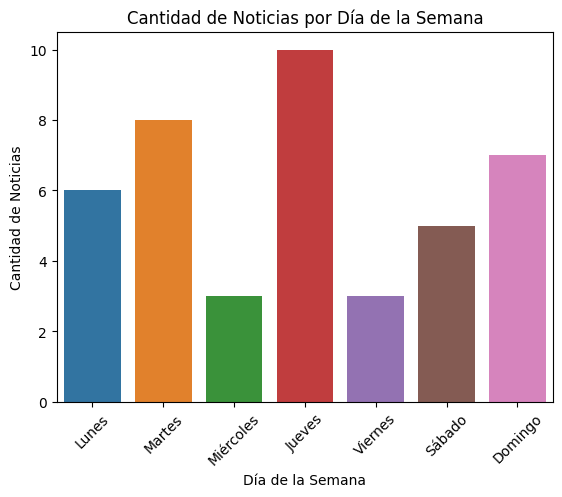

In [ ]:
# Extraer el día de la semana (0 es lunes, 6 es domingo)
df['Dia_Semana'] = df['Fecha'].dt.dayofweek

# Crear una copia de los datos para evitar SettingWithCopyWarning
data_clean = df.dropna(subset=['Dia_Semana']).copy()

# Convertir 'Dia_Semana' a tipo entero
data_clean['Dia_Semana'] = data_clean['Dia_Semana'].astype(int)

# Agrupar por día de la semana y contar el número de noticias
conteo_dias_semana = data_clean.groupby('Dia_Semana').size()

# Crear un mapeo de números a nombres de días
dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
conteo_dias_semana.index = [dias[dia] for dia in conteo_dias_semana.index]

# Crear el gráfico de barras
sns.barplot(x=conteo_dias_semana.index, y=conteo_dias_semana.values)

# Etiquetas y título
plt.xlabel('Día de la Semana')
plt.ylabel('Cantidad de Noticias')
plt.title('Cantidad de Noticias por Día de la Semana')
plt.xticks(rotation=45)
plt.show()

Se extrae el día de la semana, se crea un gráfico de barras que muestra la cantidad de noticias por día de la semana.

### 7. Análisis de noticias por día de la semana y categoría

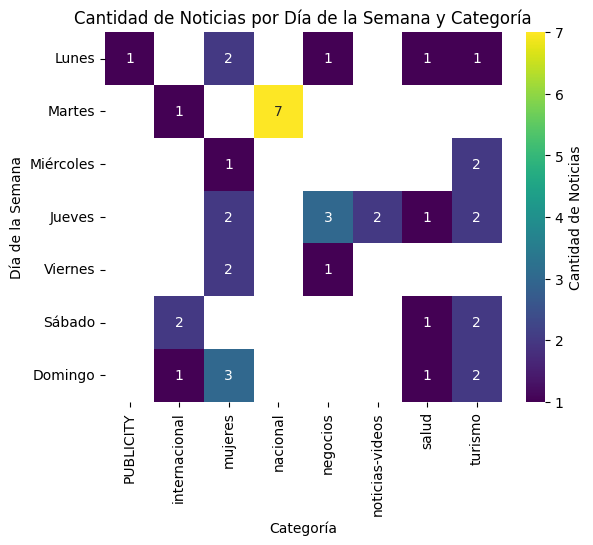

In [ ]:
# Drop rows with missing values in the 'Dia_Semana' and 'Categoria' columns
data_clean = df.dropna(subset=['Dia_Semana', 'Categoria']).copy()

# Convert 'Dia_Semana' to integer type
data_clean['Dia_Semana'] = data_clean['Dia_Semana'].astype(int)

# Group by both 'Dia_Semana' and 'Categoria' and count the occurrences
conteo_dias_categoria = data_clean.groupby(['Dia_Semana', 'Categoria']).size().unstack()

# Map the numerical day of the week to the corresponding day name
dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
conteo_dias_categoria.index = [dias[dia] for dia in conteo_dias_categoria.index]

# Plot the data using a heatmap
sns.heatmap(conteo_dias_categoria, cmap='viridis', annot=True, fmt='g', cbar_kws={'label': 'Cantidad de Noticias'})
plt.xlabel('Categoría')
plt.ylabel('Día de la Semana')
plt.title('Cantidad de Noticias por Día de la Semana y Categoría')
plt.show()